In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import fsolve

from functools import reduce

# Monday, September 25th, 2023

## Review

### What have we cover since September 18th?

## Sep 18
- Case study: Modelling epidemics (SIR)
- Python lists (indexing)
- Numpy arrays (like vectors)
- Numpy matrix

## Sep 20
- Writing our `difference()` function for generic difference equation solving
- Plot solutions of logistic map for different values of `r` (growth rate)
- Equilibrium (or attractors) $\left\{y:\exists x_{n_k}\;s.t.\;\lim_{k\to\infty}x_{n_k}=y\right\}$
- Bifurcation diagram for parameter `r` in logistic map
- Higher order difference equations (e.g. order 2: $x_{n+2}=x_n^3$)

## Sep 21
- Fixed points and periodic orbits
- `fsolve()` from `scipy.optimize`
- Scope and closure of functions
- `map()`, `filter()`, and `reduce()`
- Using the above functions to find n-periodic orbits of a difference equation

## Sep 25
- What did we learn?
- 
- 
- 

# Sep 18

[Second half of this notebook SIR Model](../../Lectures/Week%202/Lecture-2-Sep-13.ipynb)

[Slicing and solving compartmental models from Mondays lab notebook](../../Labs/Week%203/Lab-5-Sep-18.ipynb)

# Sep 20

### The logistic equation

$$ dx/dt = rx(1-x) $$
$$ x(t) = \frac{1}{Ce^{-rt}+1} $$

### The logistic map
$$ X_{n+1} = rX_{n}\left(1-\frac{X_n}{K}\right)$$
Let $x_n = X_n/K$, then
$$ x_{n+1} = rx_{n}\left(1-x_n\right)$$



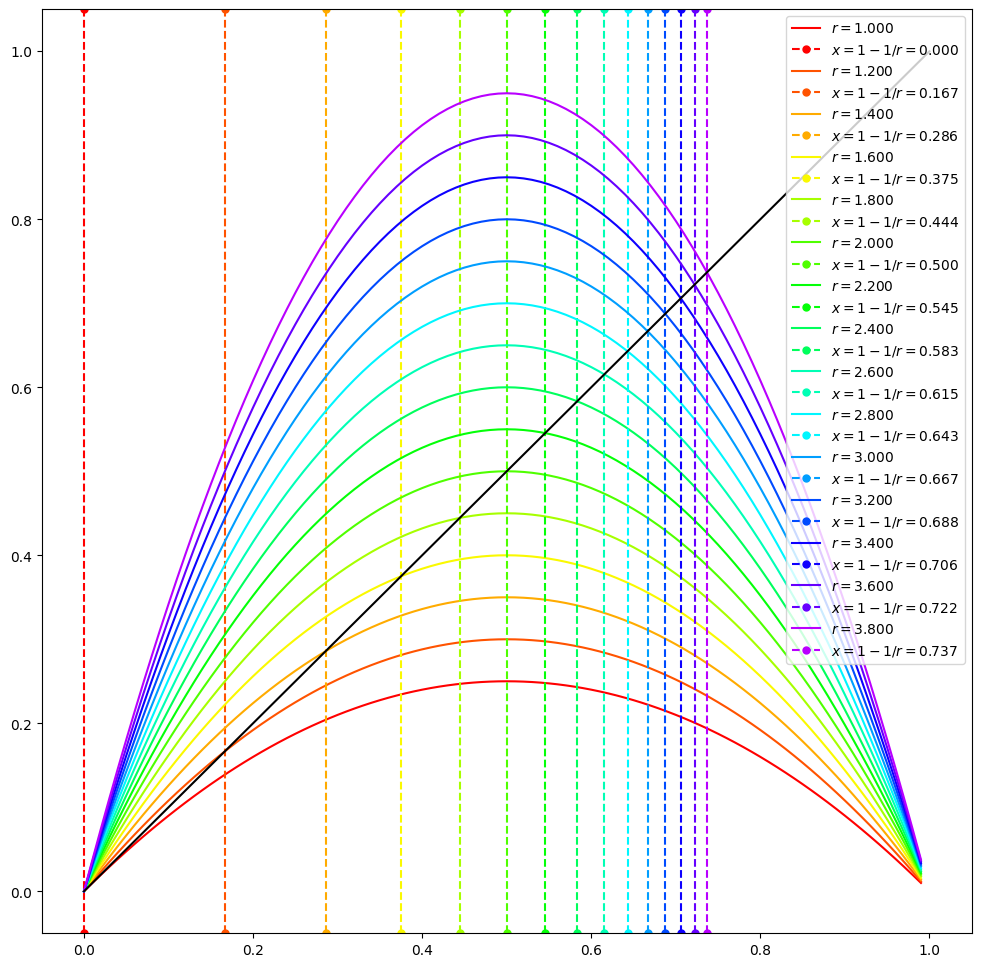

In [5]:
# setup colors
from matplotlib import cm 

def logistic(x):
    return r * x * (1 - x)

colors = [cm.hsv(x) for x in np.linspace(0, 0.8, len(np.arange(1, 4, 0.2)))]
plt.figure(figsize=(12,12))

for i, r in enumerate(np.arange(1, 4, 0.2)):
    x = np.arange(0, 1, 0.01)
    plt.plot(x, logistic(x), color=colors[i], label=f'$r = {r:.3f}$')
    plt.axvline(1 - 1/r, linestyle='--', marker='o', markersize=5, color=colors[i], label=f'$x = 1-1/r = {1-1/r:.3f}$')
plt.plot([0, 1], [0, 1], 'k')
plt.legend()

These intersections with the line $y=x$ are called **fixed points** or **equilibria**. They are the points where the function $f(x)$ intersects the line $y=x$.

so the intersections of $f(x)$ and $y=x$ we have 

$$ x = rx(1-x)$$

$$ 1 = r(1-x)$$

$$ x = 1 - \frac{1}{r}$$

[see the cheatsheet for codes that make bifurcation plot](../../cheatsheet.ipynb)

[see modified lecture notes from sep-21 for an almost correct bifurcation plot. make sure you understand why it is not correct.](../../Lectures/Week%203/Lecture-7-Sep-21.ipynb)

# Sep 21

**What is fsolve doing?**

In [197]:
fsolve(lambda x: x**2, 3000)

array([1.70431615e-80])

finds roots of a function

Higher dimensional system with fsolve


$$ f(x, y) = <x^2 - y^2 + a, 2xy + b>$$

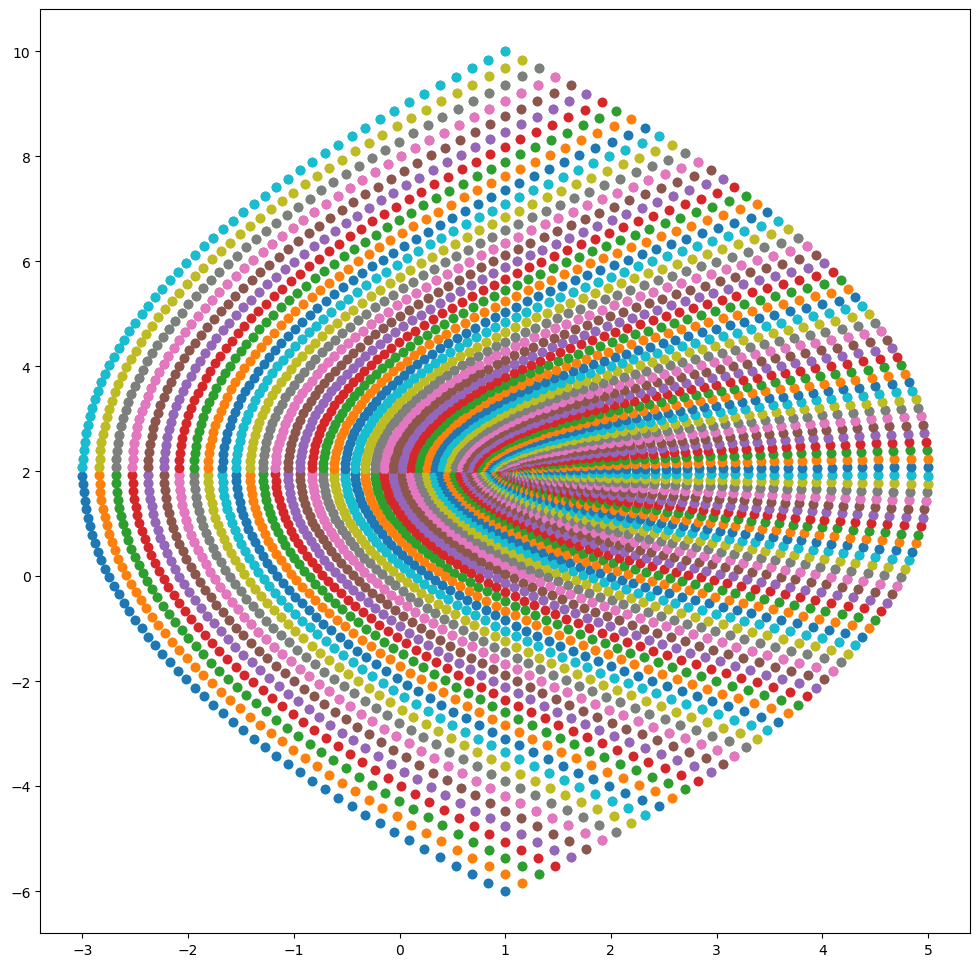

In [212]:
def f(X):
    x, y = X
    return [x**2 - y**2 + a, 2*x*y + b]

a, b = 1, 2

# demonstration of the function (has nothing to do with fsolve)
plt.figure(figsize=(12,12))
xs = np.linspace(-2, 2, 100)
ys = np.linspace(-2, 2, 100)
for x in xs:
    for y in ys:
        plt.plot(*f([x,y]), 'o')


In [216]:
print(fsolve(f, (1, 1)))
print(f(fsolve(f, (1, 1))))

[-0.78615138  1.27201965]
[-8.72191208145523e-13, -2.327027459614328e-13]


In [219]:
def f(X):
    x, y = X
    return np.array([x**2 + y**2 - 1, x - y])

print(fsolve(f, [1, 1]))
print(f(fsolve(f, [1, 1])))

[0.70710678 0.70710678]
[4.4408921e-16 0.0000000e+00]


### Some function composition in Python

In [2]:
from scipy.optimize import fsolve
from functools import reduce 

compose = lambda f, g: ( lambda x: f(g(x)) )
identity = lambda x : x
composite = lambda f, n: identity if n == 0 else reduce(compose, [f] * n)

composite(lambda x: x**2, 2)(2)

16

this is like $(2^2)^2$

or generally for $f(x) = x^2$,

$f(f(2))$

In [3]:
# this is the composite function above rewritten

def n_compositions(f, n):
    '''
    Returns a function that computes the nth composition of f.
    '''
    
    if n == 0:
        # return identity function when n = 0. no compositions just returns the input.
        return lambda x: x

    return reduce(lambda f, g: lambda x: f(g(x)), [f] * n)

### smart idea is to pass the output of n_compositions into fsolve() to find the fixed points of the nth composition of f(x).

In [7]:
n = 3
r = 3.83

x = fsolve( lambda x: n_compositions(logistic, n)(x) - x, 0.6)

for i in range(n+1):
    print(n_compositions(lambda x: logistic(x), i)(x))

[0.52400053]
[0.95529382]
[0.16356986]
[0.52400053]


note we are not directly passing the output of n_compositions into fsolve(). we are passing in a function that calls n_compositions(x) and then subtracts x.

this is the same idea as we see in midterm 1.

### Connecting to the lab...



As we increase $b$, the solution may not converge to an equilibrium as time $t\to\infty$. Instead, we may see a periodic orbit.

a) Find a $b$ value such that the solution is 2-period.

b) If you keep increasing $b$, can you find solutions with other periods?

c) Follow the example in the class to plot the Bifurcation diagram of this model, using $b$ as the bifurcation parameter (i.e., a plot showing the change in the attractor with the change of $b$).


In [8]:
# this is like the difference function from class.

def run(f, x0, a=0.001, b=0.2, s=0.001, iterations=10000):
    '''
    Return a list of x values for the difference equation with function f, starting at x0, and iterating iterations times.
    '''
    xs = [x0]
    for i in range(iterations):
        xs.append(f(xs[-1], a, b, s))

    return xs

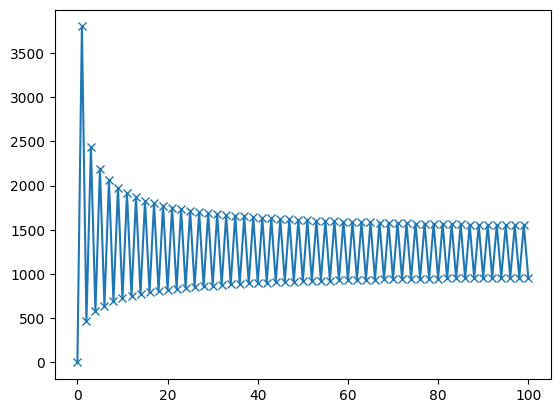

In [9]:
xs = run(lambda x,a,b,s: b*np.exp(-a*x)+s*x, 0.1, a=0.001, b=3800, s=0.1, iterations=100)
plt.plot(xs, '-x')

how can we use the n_compositions function with fsolve to show this is a 2-periodic orbit?

In [10]:
a = 0.001
b = 3800
s = 0.1

n = 2

x = fsolve(lambda x: n_compositions(lambda x: b*np.exp(-a*x)+s*x, n)(x) - x, 0.1)

for i in range(n+1):
    print(n_compositions(lambda x: b*np.exp(-a*x)+s*x, i)(x))

[981.58014867]
[1522.0883902]
[981.58014867]


what if we look for an odd numbered orbit?

In [11]:
a = 0.001
b = 3800
s = 0.1

n = 3

x = fsolve(lambda x: n_compositions(lambda x: b*np.exp(-a*x)+s*x, n)(x) - x, 0.1)

for i in range(n+1):
    print(n_compositions(lambda x: b*np.exp(-a*x)+s*x, i)(x))

[1231.84695215]
[1231.84695215]
[1231.84695215]
[1231.84695215]


why is this different from just passing logistic(x) - x into fsolve?

In [12]:
fsolve(lambda x: b*np.exp(-a*x)+s*x - x, 0.1)

array([1231.84695215])

we have more control over the equilibrium we are looking for.

Now for example what if we wanted to find a 4-periodic orbit?

[782.91800543]
[13790.40169418]
[1379.07093222]
[7692.27894917]
[782.91800543]


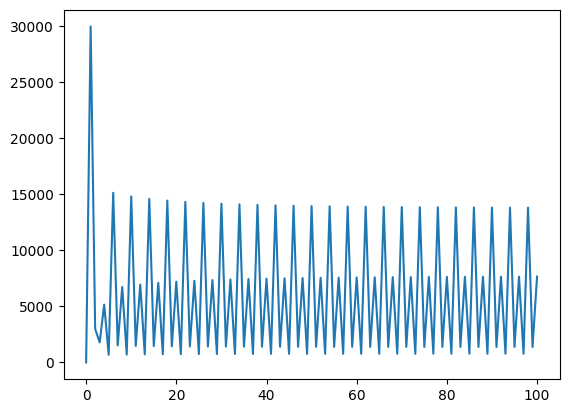

In [15]:
a=0.001
b=30000 # change this from 3800 so there is actually 4 equilibrium
s=0.1

n = 4

x = fsolve(lambda x: n_compositions(lambda x: b*np.exp(-a*x)+s*x, n)(x) - x, 0.1)

for i in range(n+1):
    print(n_compositions(lambda x: b*np.exp(-a*x)+s*x, i)(x))

vals = run(lambda x,a,b,s: b*np.exp(-a*x)+s*x, 0.1, a=0.001, b=30000, s=0.1, iterations=100)
plt.plot(vals)

this is difficult to come up with, and I am not sure I would do it like this if I tried from scratch,

but it should not be too bad to apply this code to other situations.